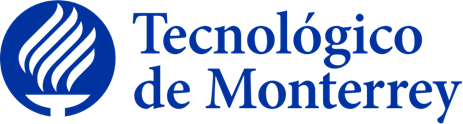

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Evaluación Modelo Final**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

In this notebook we will be evaluating our final model. The library that we will use for the model evaluation is Deepeval.

### 1. First, we load the libraries

In [9]:
from deepeval import evaluate
from deepeval.evaluate import aggregate_metric_pass_rates
from deepeval.metrics import AnswerRelevancyMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from unsloth import FastLanguageModel
from peft import PeftModel
# from unsloth import FastLanguageModel
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import json
from dotenv import load_dotenv
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.modeling_utils import PreTrainedModel

from deepeval.dataset.golden import Golden
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import re


In [2]:
#Activated, the notebook will execute only a few testcases for demostrantion purposes
demo_mode = True
model_name = "unsloth/llama-3-8b-bnb-4bit"
dataset_url = "JonathanGarza/legal-mx-instruction-dataset-1-3-inst-ft-prompts"
peft_model_name = 'JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v3'

### 2. Functions Definition

In this section we define a few helper functions that we will be using for setting the test cases and generating the response from our model.

In [28]:
def extract_response(response: str) -> str|None:
    '''
    This function extracts only the answer from the model output
    '''
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    '''
    Create a test case from a dictionary of datapoints
    '''
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )
    
def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
    '''
    Generates the response from the model
    '''
    
    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 650, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)
    
    return extract_response(result[0])

def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
    '''
    Generates all the test cases from a list of datapoints (called Goldens in deepeval)
    '''
    test_cases = []
    
    if isinstance(datapoints, Dataset):
        datapoints = convert_hugging_face_dataset_to_goldens(datapoints)
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        if (isinstance(golden, Golden)):
            datapoint = json.loads(golden.model_dump_json())
        
        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases

def exclude_test_cases_with_empty_outputs(testcases: list[LLMTestCase], print_results = True)->list[LLMTestCase]:
    cleaned_testcases = []
    for index,testcase in enumerate(testcases):
        if type(testcase.actual_output) == str:
            cleaned_testcases.append(testcases.pop(index))
            continue
    
    if print_results:
        print (f'A total of {len(testcases) - len(cleaned_testcases)} testcases were removed from the set')
    return cleaned_testcases 

def convert_hugging_face_dataset_to_goldens(dataset: Dataset)->list[Golden]:
    
    goldens = []
    
    for datapoint in dataset:
        if (type(datapoint['context']) != str): 
            continue#We need context for some tests
        test_case = Golden(
            input = datapoint['instruction'],
            expected_output = datapoint['output'],
            context = [datapoint['context']]
        )
        
        goldens.append(test_case)
        
    return goldens
        
        


### 2. Creating the test dataset

For creating the dataset, we need to access OpenAI Api since we'll be using a synthetic dataset created from the law files used for this project.

In [ ]:
dataset = load_dataset(dataset_url)
test_set = dataset['test']

In [4]:
load_dotenv()

True

### 3. Setting up the Finetuned Model

We proceed to download the main model, which was a quantized version of the Llama-3-8b. In order to run this code, it'necessary to have cuda device.

In [10]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,
    device_map='cuda',
    load_in_4bit = True,
)


==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 4070 Laptop GPU. Max memory: 7.996 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now we donwload the PEFT model containing the trained weights

In [11]:

model = PeftModel.from_pretrained(model, model_id=peft_model_name)
FastLanguageModel.for_inference(model)

We define the prompt that we will provide to the Llama Model

In [12]:
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

### 4. Evaluating the Model

First, let's load the dataset containing all the goldens

Now, we create the test cases from the goldens. For the real evaluation we used 250+ testcases, For demonstration purposes, we will use only 10 testcases.

In [14]:
len(test_set)

897

In [15]:
test_cases = generate_test_cases(model, tokenizer, test_set, alpaca_based_prompt)
test_cases[:5]

Generating test cases: 100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


[LLMTestCase(input='¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?', actual_output='La nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica son criterios de ingreso a la Armada de México, de acuerdo con el Artículo 10 de la Ley Orgánica de la Armada de México. Estos criterios deben ser considerados al momento de evaluar a los aspirantes para determinar su idoneidad para servir en la Armada.', expected_output='Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y políticos.', context=['\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\nXI. Trabajo Social Naval, y\n\nFracción reformada DOF 31-1

Sometimes the Llama model generates an empty response. Due to time constraints, we were not able to investigate this unexpected behaviour. Since a testcase with empty output would generate an error during evaluation, we must exclude it here from the test dataset.

In [16]:
test_cases = exclude_test_cases_with_empty_outputs(test_cases)

A total of 0 testcases were removed from the set


In [17]:
dataset = EvaluationDataset(test_cases)

We will evaluating our model against three metrics:

* Hallucination
* Correctness
* Answer Relevancy

The evaluation process uses GPT-3.5-turbo under the hood. So, it's necessary to have an OpenAI Key in order to run this section of the notebook.

On another note, we are using conservative threshold values since all the datasets that were used in this project were synthetic. It's reasonable to expect that the model's performance has been affected by this.

In [18]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

No we get the results from the evaluation

In [ ]:
results = evaluate(dataset, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=False)

Now we print the scores:

In [20]:
scores = aggregate_metric_pass_rates(results)

if not demo_mode:
    with open('./test_results/test_results.json', 'w') as f:
        json.dump(scores, f)



Overall Metric Pass Rates

HallucinationMetric: 0.00% pass rate
AnswerRelevancyMetric: 60.00% pass rate
GEval: 60.00% pass rate




In case the notebook is in demo mode, we load the real scores and print them out:

In [21]:
if demo_mode:
    with open('./test_results/test_results.json') as f:
        scores = json.load(f)
        
    print("\n" + "=" * 70 + "\n")
    print("Overall Metric Pass Rates\n")
    for metric, pass_rate in scores.items():
        print(f"{metric}: {pass_rate:.2%} pass rate")
    print("\n" + "=" * 70 + "\n")




Overall Metric Pass Rates

HallucinationMetric: 4.03% pass rate
AnswerRelevancyMetric: 92.62% pass rate
GEval: 89.93% pass rate




### 5. Conclusions

The model has a good performance on the GEval and Answer Relevancy metrics (92.62% and 89.93$ respectively). Nonetheless, the hallucination metric is not satisfactory (4.03%) and must be improved. There are several steps that can be taken in order to improve this metric:

* Train the model in a larger dataset (currently we used 5,000 entries)
* Use human annotators for creating high quality datasets
* Train other models and compare to the one used in this project.

Because the model has low score in the hallucination metric, it's still not ready for production.